Using 2 GPUs
100
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              SiLU-5         [-1, 64, 224, 224]               0
              SiLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             SiLU-11         [-1, 64, 224, 224]               0
             SiLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,928
           Conv2d-14  

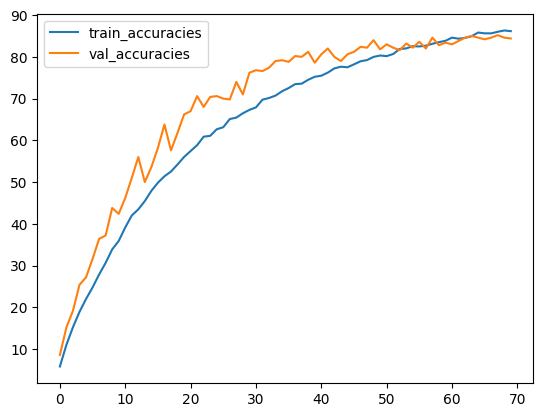

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.init as init

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()  
print(f"Using {num_gpus} GPUs")

paths = {
    'train': '/kaggle/input/sports-classification/train',
    'valid': '/kaggle/input/sports-classification/valid',
    'test': '/kaggle/input/sports-classification/test'
}
print(len(os.listdir(paths['train'])))

def loadImage(path):
    return Image.open(path)

batch_size = 64
img_size = 224

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((img_size,img_size)),
    transforms.RandomCrop(224,padding=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4713, 0.4699, 0.4548],std=[0.2931, 0.2850, 0.2986]),
    transforms.RandomErasing(p = 0.75,
                             scale=(0.01,0.3),
                             ratio=(1.0,1.0),
                             value=0,
                             inplace=True)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4713, 0.4699, 0.4548],std=[0.2931, 0.2850, 0.2986])
])

train_data = datasets.ImageFolder(
    root=paths['train'],
    loader=loadImage,
    transform=train_transform
)

test_data = datasets.ImageFolder(
    root=paths['test'],
    transform=test_transform
)

valid_data = datasets.ImageFolder(
    root=paths['valid'],
    transform=test_transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3,64,3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(64,64,3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(64,64,3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2,2)
        )
        self.skip_1 = nn.Sequential(
            nn.Conv2d(3,64,3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(64,128,3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.SiLU()
        )
        self.conv_5 = nn.Sequential(
            nn.Conv2d(128,128,3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )
        self.conv_6 = nn.Sequential(
            nn.Conv2d(128,128,3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d(2,2),
        )
        self.skip_2 = nn.Sequential(
            nn.Conv2d(64,128,3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU()
        )

        self.conv_7 = nn.Sequential(
            nn.Conv2d(128,256,3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )
        self.conv_8 = nn.Sequential(
            nn.Conv2d(256,256,3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )
        self.conv_9 = nn.Sequential(
            nn.Conv2d(256,256,3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.MaxPool2d(2,2)
        )
        self.skip_3 = nn.Sequential(
            nn.Conv2d(128,256,3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )

        self.conv_10 = nn.Sequential(
            nn.Conv2d(256,512,3,stride=1,padding='same'),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )
        self.conv_11 = nn.Sequential(
            nn.Conv2d(512,512,3,stride=1,padding='same'),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )
        self.conv_12 = nn.Sequential(
            nn.Conv2d(512,512,3,stride=1,padding='same'),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.MaxPool2d(2,2)
        )
        self.skip_4 = nn.Sequential(
            nn.Conv2d(256,512,3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )

        self.avgpool = nn.AvgPool2d(kernel_size=14)

        self.dense_1 = nn.Sequential(
            nn.Linear(512,256),
            nn.SiLU(),
            nn.Dropout(p=0.5)
        )
        self.dense_3 = nn.Sequential(
            nn.Linear(256,n_classes)
        )
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m,nn.Conv2d):
            init.kaiming_normal_(m.weight,nonlinearity='linear')
            if m.bias is not None:
              init.zeros_(m.bias)
          elif isinstance(m,nn.Linear):
            init.kaiming_normal_(m.weight,nonlinearity='linear')
            if m.bias is not None:
              init.zeros_(m.bias)

    def forward(self, x):
        prev = x
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        res = self.skip_1(prev)
        x = x + res

        prev = x
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.conv_6(x)
        res = self.skip_2(prev)
        x = x + res

        prev = x
        x = self.conv_7(x)
        x = self.conv_8(x)
        x = self.conv_9(x)
        res = self.skip_3(prev)
        x = x + res

        prev = x
        x = self.conv_10(x)
        x = self.conv_11(x)
        x = self.conv_12(x)
        res = self.skip_4(prev)
        x = res + x

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        x = self.dense_3(x)
        return x

model = CNNModel(100)
model = model.to(device)
if num_gpus > 1:
    model = nn.DataParallel(model, device_ids=[0, 1])  
summary(model, (3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
decay_Rate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_Rate)

# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 70
best_val_acc = 0.0
best_model_path = 'best_model.pth'

# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    val_loss, val_accuracy = evaluate(model, valid_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Save the model if validation accuracy improves
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(val_loss)
    test_accuracies.append(val_accuracy)
    lr_scheduler.step()

# Plotting
plt.plot(train_accuracies, label='train_accuracies')
plt.plot(test_accuracies, label='val_accuracies')
plt.legend()
plt.savefig('accuracy_plot.png')

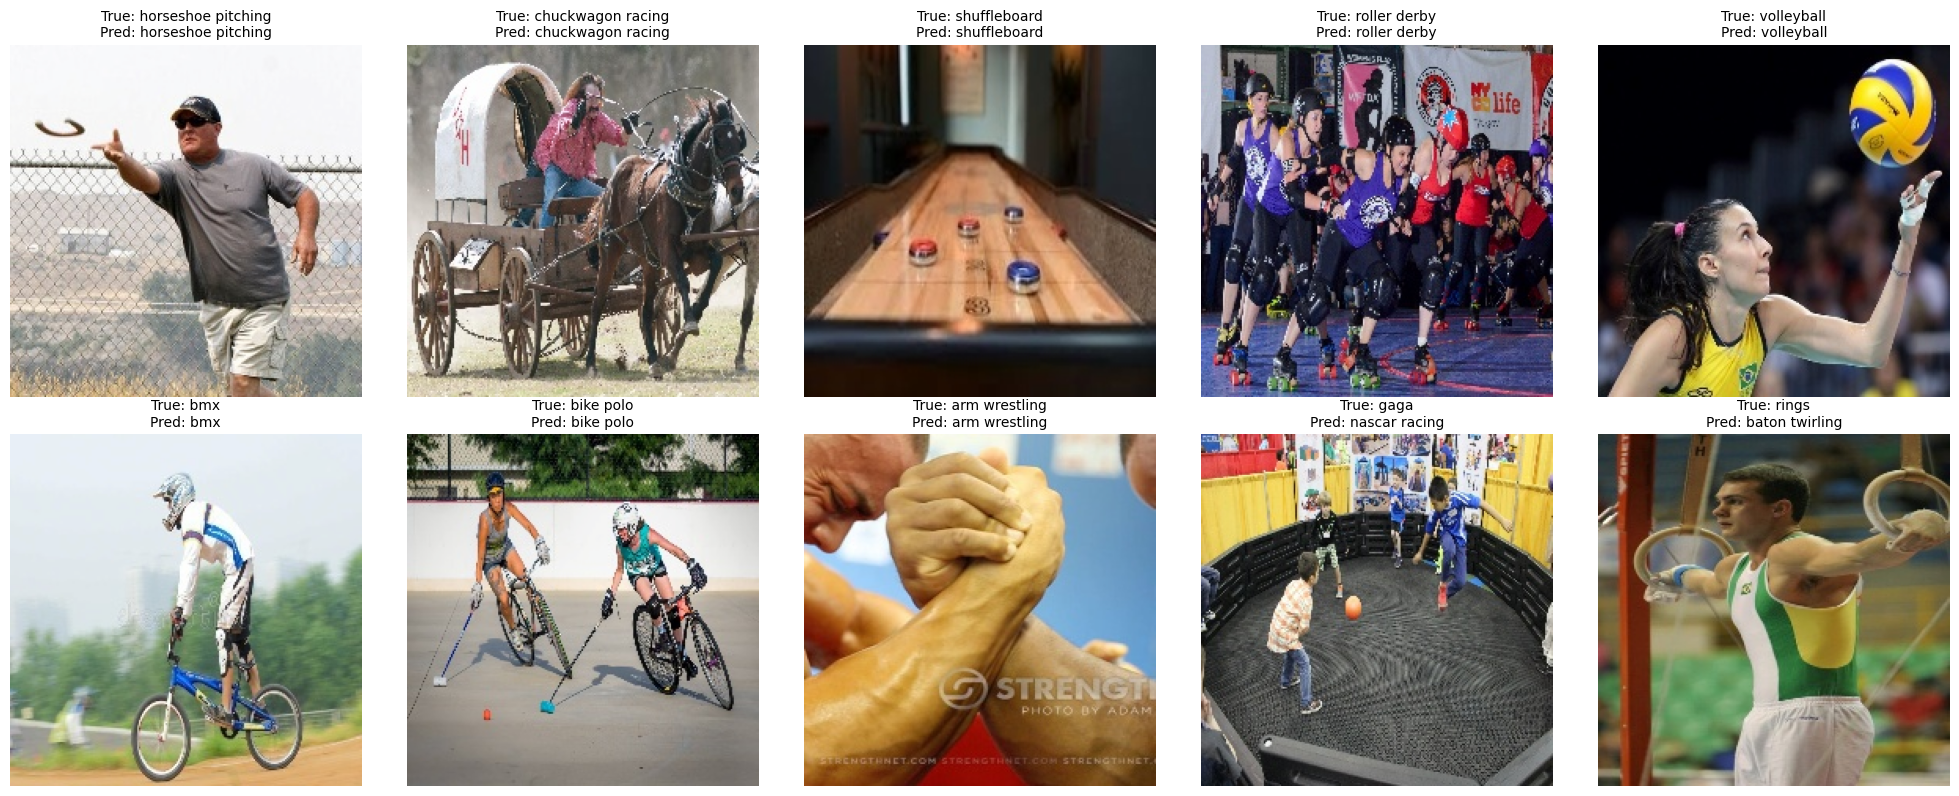

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import SubsetRandomSampler


num_images = 10


indices = random.sample(range(len(test_data)), num_images)
sampler = SubsetRandomSampler(indices)
random_loader = torch.utils.data.DataLoader(test_data, batch_size=1, sampler=sampler)


model = CNNModel(n_classes=100).to(device)


state_dict = torch.load('best_model.pth', map_location=device, weights_only=True)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value
model.load_state_dict(new_state_dict)
model.eval()


class_names = test_data.classes


plt.figure(figsize=(20, 8))
for i, (image, true_label) in enumerate(random_loader):
    image, true_label = image.to(device), true_label.to(device)
    

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    

    img = image.squeeze().cpu().numpy().transpose(1, 2, 0)

    img = img * np.array([0.2931, 0.2850, 0.2986]) + np.array([0.4713, 0.4699, 0.4548])
    img = np.clip(img, 0, 1)
    
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label.item()]}\nPred: {class_names[predicted.item()]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()